<a href="https://colab.research.google.com/github/ZatoCreW/TextMiningProject/blob/main/CZato_TMFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import spacy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from scipy.linalg import norm
import re
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import math
from tqdm.notebook import tqdm
import random

In [ ]:
# Load data
fake = pd.read_csv('https://github.com/ZatoCreW/TextMiningProject/blob/main/data/Fake.csv?raw=true')
true = pd.read_csv('https://github.com/ZatoCreW/TextMiningProject/blob/main/data/True.csv?raw=true')

In [ ]:
# Modified helper functions to compute token importance. Extracted from lecture Notebook 3
def compute_token_importance(clf, text):
    tokens = re.split(r'\W+', text.strip())
    initial_text = " ".join(tokens)
    initial_class_distribution = clf.predict_proba([initial_text])[0]
    token_importances = []
    for i, token in enumerate(tokens):
        masked_tokens = tokens[:]
        masked_tokens[i] = "<UNKNOWN>"
        masked_text = " ".join(masked_tokens)
        masked_class_distribution = clf.predict_proba([masked_text])[0]
        token_importance = norm(initial_class_distribution - masked_class_distribution)
        token_importances.append((token, token_importance))
    return token_importances


def display_token_importance(token_importances):
    min_token_importance = min([ti[1] for ti in token_importances])
    max_token_importance = max([ti[1] for ti in token_importances])
    html_tokens = []
    for token, importance in token_importances:
        if max_token_importance == min_token_importance:
            r = 0.5
        else:
            r = (importance - min_token_importance) / (max_token_importance - min_token_importance)
        color = "rgba(0, 0, 255, {})".format(0.8 * r + 0.2)
        html_tokens.append("<span style='color:{}'>{}</span>".format(color, token))
    display(HTML(" ".join(html_tokens)))

# Preliminary Analysis

In [ ]:
print(f'{len(fake)} articles in false news dataset')
fake.head()

23481 articles in false news dataset


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
print(f'{len(true)} articles in true news dataset')
true.head()

21417 articles in true news dataset


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
nlp = spacy.load("en", disable=["parser", "ner", "tagger"])

Average number of tokens in fake news dataset: 492
Average number of tokens in true news dataset: 446


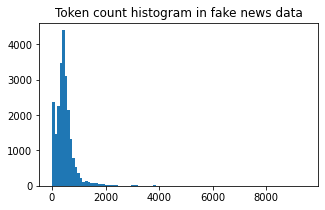

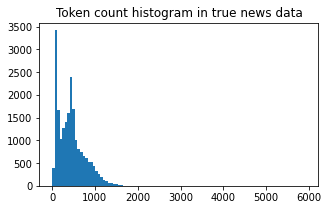

In [ ]:
fake_tokens_count = 0
fake_len_hist = list()

for i in range(len(fake)):
  text = nlp(fake['text'][i])
  fake_len_hist.append(len(text))
  fake_tokens_count += len(text)


true_tokens_count = 0
true_len_hist = list()

for i in range(len(true)):
  text = nlp(true['text'][i])
  true_len_hist.append(len(text))
  true_tokens_count += len(text)


print(f'Average number of tokens in fake news dataset: {round(fake_tokens_count/len(fake))}')
print(f'Average number of tokens in true news dataset: {round(true_tokens_count/len(true))}')

plt.figure(figsize=(5, 3))
plt.title('Token count histogram in fake news data')
plt.hist(fake_len_hist, bins=100)
plt.show()

plt.figure(figsize=(5, 3))
plt.title('Token count histogram in true news data')
plt.hist(true_len_hist, bins=100)
plt.show()

Side note: interesting to see that fake news have a distribution skewed towards the left but average number of token is larger. Thus, there are more outliers with long texts despite median fake news is shorter than the true median

# Classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
fake['label'] = 1
true['label'] = 0
data = pd.concat([fake, true])
texts = data['text']
y = data['label']
texts_train, texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.3, shuffle=True, random_state=1)

In [ ]:
"""
vec = TfidfVectorizer()
vec.fit(texts_train)
X_train = vec.transform(texts_train)
X_test = vec.transform(texts_test)


sgd_clf = SGDClassifier(max_iter=100, loss='log', random_state=0)

pipeline = Pipeline([
    ("vec", vec),
    ("clf", sgd_clf),
])
param_grid = {
    "vec__stop_words": ["english"],
    "vec__ngram_range": [(1, 1), (1, 2)],
    "clf__alpha": [1e-4, 1e-3, 1e-2],
}

pipeline_grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)
pipeline_grid_search.fit(texts_train, y_train)
print(f'Optimal parameter combination {pipeline_grid_search.best_params_}')

pipeline.fit(texts_train, y_train)
print("Accuracy on train:", round(accuracy_score(y_train, pipeline.predict(texts_train)), 4))

pipeline.fit(texts_test, y_test)
print("Accuracy on test:", round(accuracy_score(y_test, pipeline.predict(texts_test)), 4))
"""
# I'm commenting this out because it takes 15min to run
# best_params: {'clf__alpha': 0.0001, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english'}

'\nvec = TfidfVectorizer()\nvec.fit(texts_train)\nX_train = vec.transform(texts_train)\nX_test = vec.transform(texts_test)\n\n\nsgd_clf = SGDClassifier(max_iter=100, loss=\'log\', random_state=0)\n\npipeline = Pipeline([\n    ("vec", vec),\n    ("clf", sgd_clf),\n])\nparam_grid = {\n    "vec__stop_words": ["english"],\n    "vec__ngram_range": [(1, 1), (1, 2)],\n    "clf__alpha": [1e-4, 1e-3, 1e-2],\n}\n\npipeline_grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)\npipeline_grid_search.fit(texts_train, y_train)\nprint(f\'Optimal parameter combination {pipeline_grid_search.best_params_}\')\n\npipeline.fit(texts_train, y_train)\nprint("Accuracy on train:", round(accuracy_score(y_train, pipeline.predict(texts_train)), 4))\n\npipeline.fit(texts_test, y_test)\nprint("Accuracy on test:", round(accuracy_score(y_test, pipeline.predict(texts_test)), 4))\n'

In [ ]:
vec = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
vec.fit(texts_train)
X_train = vec.transform(texts_train)
X_test = vec.transform(texts_test)
sgd_clf = SGDClassifier(alpha = 1e-4, max_iter=100, loss='log', random_state=0)
pipeline = Pipeline([
    ("vec", vec),
    ("clf", sgd_clf),
])

pipeline.fit(texts_train, y_train)
print("Accuracy on train:", round(accuracy_score(y_train, pipeline.predict(texts_train)), 4))
pipeline.fit(texts_test, y_test)
print("Accuracy on test:", round(accuracy_score(y_test, pipeline.predict(texts_test)), 4))

Accuracy on train: 0.9828
Accuracy on test: 0.9909


In [ ]:
from IPython.display import HTML, display
#print("categories:", ", ".join(dataset.target_names))
for text, label in zip(texts_train[:20], y_train[:20]):
    label = str(label) # 1 = fake
    display(HTML("<hr>"))
    display(HTML(label))  # uncomment this line to see the true label
    token_importances = compute_token_importance(pipeline, text)
    display_token_importance(token_importances)
    display(HTML("<hr>"))

Clean data to avoid leakages: remove source from true and fake. \
I'm just rerunning everything with clean data

In [ ]:
# Clean source from true
for i in range(len(true)):
  t = fake['text'][i]
  true['text'][i] = '-'.join(true['text'][i].split('-')[1:])
  has_reuters = bool(re.search('Reuters', t))
  if has_reuters:
    fake['text'][i] = t.replace('Reuters ', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# We check that text is good now
true.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",0


In [ ]:
# Clean feat/photo from false
for i in range(len(fake)):
  t = fake['text'][i]
  # Main leakages are 'Featured image', 'Photo by _name_' and '@twitter_user'
  has_feat = bool(re.search('Featured image', t))
  has_featI = bool(re.search('Featured Image', t))
  has_photoby = bool(re.search('Photo by', t))
  has_twitter = bool(re.search(r'@([A-Za-z0-9_]+)', t))
  if has_feat:
    idx1 = t.find('Featured image')
    fake['text'][i] = t[:idx1]
  if has_photoby:
    idx2 = t.find('Photo by')
    fake['text'][i] = t[:idx2]
  if has_featI:
    idx3 = t.find('Featured Image')
    fake['text'][i] = t[:idx3]
  if has_twitter:
    fake['text'][i] = re.sub(r'@([A-Za-z0-9_]+)', '', fake['text'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_la

In [ ]:
# 'Photo by Andrew Burton/Getty Images.' successfully removed
pprint(fake['text'][0])

('Donald Trump just couldn t wish all Americans a Happy New Year and leave it '
 'at that. Instead, he had to give a shout out to his enemies, haters and  the '
 'very dishonest fake news media.  The former reality show star had just one '
 'job to do and he couldn t do it. As our Country rapidly grows stronger and '
 'smarter, I want to wish all of my friends, supporters, enemies, haters, and '
 'even the very dishonest Fake News Media, a Happy and Healthy New Year,  '
 'President Angry Pants tweeted.  2018 will be a great year for America! As '
 'our Country rapidly grows stronger and smarter, I want to wish all of my '
 'friends, supporters, enemies, haters, and even the very dishonest Fake News '
 'Media, a Happy and Healthy New Year. 2018 will be a great year for America!  '
 'Donald J. Trump () December 31, 2017Trump s tweet went down about as welll '
 'as you d expect.What kind of president sends a New Year s greeting like this '
 'despicable, petty, infantile gibberish? Only Tr

In [ ]:
fake['label'] = 1
true['label'] = 0
data = pd.concat([fake, true])
texts = data['text']
y = data['label']
texts_train, texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.3, shuffle=True, random_state=1)

In [ ]:
vec = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
vec.fit(texts_train)
X_train = vec.transform(texts_train)
X_test = vec.transform(texts_test)
sgd_clf = SGDClassifier(alpha = 1e-4, max_iter=100, loss='log', random_state=0)
pipeline = Pipeline([
    ("vec", vec),
    ("clf", sgd_clf),
])

pipeline.fit(texts_train, y_train)
print("Accuracy on train:", round(accuracy_score(y_train, pipeline.predict(texts_train)), 4))
pipeline.fit(texts_test, y_test)
print("Accuracy on test:", round(accuracy_score(y_test, pipeline.predict(texts_test)), 4))

Accuracy on train: 0.976
Accuracy on test: 0.9861


In [ ]:
from IPython.display import HTML, display
#print("categories:", ", ".join(dataset.target_names))
for text, label in zip(texts_train[:20], y_train[:20]):
    label = str(label) # 1 = fake
    display(HTML("<hr>"))
    display(HTML(label))  # uncomment this line to see the true label
    token_importances = compute_token_importance(pipeline, text)
    display_token_importance(token_importances)
    display(HTML("<hr>"))

Well, test accuracy keeps being larger than train accuracy. I read in the discussion that there are like 5000 duplicate articles meaning that it's likely that some articles are both in training and test dataset. If I had more time I would do more extensive cleaning.

# Topic Modelling

In [ ]:
# Helper functions from lecture Notebook 4

def get_top_topic_words(lda, dictionary, k=10):
    top_words = dict()
    for topicid in range(lda.num_topics):
        top_words[topicid] = [dictionary[tokenid] for tokenid, _ in lda.get_topic_terms(topicid, k)]
    return top_words


def topic_coherence(documents, topic_words, window_size=10):
    from collections import Counter
    from itertools import combinations

    words_count = Counter()
    word_pairs_count = Counter()
    num_windows = 0
    for document in documents:
        for window_start in range(max(0, len(document) - window_size) + 1):
            num_windows += 1
            window = document[window_start:window_start + window_size]
            for w in window:
                words_count[w] += 1
            for word_pair in combinations(sorted(window), 2):
                assert word_pair[0] <= word_pair[1]
                word_pairs_count[word_pair] += 1

    scores = []
    for topic_word_pair in combinations(sorted(topic_words), 2):
        assert topic_word_pair[0] <= topic_word_pair[1]
        P_w1_w2 = word_pairs_count[topic_word_pair] / num_windows
        P_w1 = words_count[topic_word_pair[0]] / num_windows
        P_w2 = words_count[topic_word_pair[1]] / num_windows
        # Coherence uses point-wise information (PMI)
        score = np.log(P_w1_w2 / (P_w1 * P_w2))
        scores.append(score)
    return np.mean(scores)


def tokens(s: str):
    return [t.lemma_ for t in nlp(s) if t.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]

In [ ]:
nlp = spacy.load("en", disable=['parser', 'ner'])
train_documents = [tokens(t) for t in tqdm(texts_train, desc="tokenize")]

tokenize:   0%|          | 0/31428 [00:00<?, ?it/s]

In [ ]:
dictionary = Dictionary(train_documents)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in train_documents]

print("dictionary word with index 0:", dictionary[0])
print("Example of BOW representation:", corpus[0])
print('Number of unique tokens:', len(dictionary))
print('Number of documents:', len(corpus))

dictionary word with index 0: adviser
Example of BOW representation: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 4), (54, 3), (55, 2), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 2), (100, 2), (101, 3), (102, 1), (103, 1), 

Question: I have no prior on the number of topics. Gensim ouputs 20 topics, I guess this is what the model believes to be the K that maximizes clustering quality,

In [ ]:
lda = LdaModel(
    corpus,
    id2word=dictionary.id2token,
    num_topics=5  # K=5 maximizes topic coherence
)

print("LDA topics:")
lda.print_topics()

LDA topics:


[(0,
  '0.007*"military" + 0.007*"government" + 0.006*"force" + 0.006*"year" + 0.006*"people" + 0.006*"state" + 0.006*"law" + 0.006*"group" + 0.005*"refugee" + 0.005*"country"'),
 (1,
  '0.012*"police" + 0.008*"people" + 0.006*"man" + 0.005*"attack" + 0.005*"group" + 0.005*"officer" + 0.005*"take" + 0.004*"protest" + 0.004*"other" + 0.004*"when"'),
 (2,
  '0.007*"year" + 0.006*"more" + 0.006*"government" + 0.006*"state" + 0.006*"tax" + 0.005*"country" + 0.005*"bill" + 0.005*"could" + 0.005*"make" + 0.005*"also"'),
 (3,
  '0.012*"election" + 0.009*"campaign" + 0.007*"party" + 0.007*"former" + 0.007*"vote" + 0.006*"state" + 0.006*"presidential" + 0.006*"official" + 0.005*"republican" + 0.005*"russian"'),
 (4,
  '0.020*"s" + 0.009*"go" + 0.008*"people" + 0.008*"just" + 0.008*"make" + 0.007*"when" + 0.007*"can" + 0.007*"so" + 0.006*"know" + 0.005*"think"')]

In [ ]:
for topic, topic_words in get_top_topic_words(lda, dictionary, k=10).items():
    print(topic, topic_coherence(train_documents, topic_words))

0 -0.008684520953090523
1 0.2275875566318555
2 -0.026736158413398162
3 0.4629878196519951
4 0.34003979286081637


In [ ]:
!pip install -q pyldavis
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 1.7 MB 13.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.118566  0.092547       1        1  30.419568
2      0.114835  0.010709       2        1  22.740403
3      0.071853  0.069149       3        1  21.466578
0      0.026150 -0.095321       4        1  12.956317
1     -0.094273 -0.077085       5        1  12.417133, topic_info=          Term          Freq         Total Category  logprob  loglift
117          s  38642.000000  38642.000000  Default  30.0000  30.0000
187   election  17203.000000  17203.000000  Default  29.0000  29.0000
862     police   8945.000000   8945.000000  Default  28.0000  28.0000
1373       tax   7453.000000   7453.000000  Default  27.0000  27.0000
390   military   8150.000000   8150.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
223       more   2402.207931  25734.062769   Topic5  -5.6556  -0.2853
502        day   1997.997064  11362.106941   Topic5  -5.8399   0.3480
78      medium   1945.383478  10402.723772   Topic5  -5.8666   0.4095
117          s   2350.494773  38642.143018   Topic5  -5.6774  -0.7136
3         also   2131.523854  21591.643888   Topic5  -5.7752  -0.2294

[527 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
689        1  0.869976       #
689        2  0.000987       #
689        3  0.001975       #
689        4  0.001975       #
689        5  0.125411       #
...      ...       ...     ...
477        2  0.041907  yemeni
477        4  0.949887  yemeni
477        5  0.006984  yemeni
13990      2  0.981251    yuan
13990      5  0.012266    yuan

[1654 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2])

# Neural Networks with PyTorch

In [ ]:
!pip install torch

In [ ]:
import torch
import torch.nn as nn

class ClassificationLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.hidden_size = hidden_size

    def forward(self, x):
        h0 = torch.zeros(1, 1, self.hidden_size)
        c0 = torch.zeros(1, 1, self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.out(out[-1, :, :])

        return self.softmax(out)

In [ ]:
def process_sequence_classification_lstm(lstm, target_tensor, input_tensor, learning_rate):
    loss_function = nn.NLLLoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    output = lstm(input_tensor)
    loss = loss_function(output, target_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
def tensorize(i):
  text = np.asarray(texts_train)[i].split()       # Split text into list of words
  tensor = torch.zeros(len(text), 1, vec_length)  # tensor(shape=(text_length, 1, embed_length))
  for i in range(len(text)):
    tensor[i] = torch.tensor(nlp(text[i]).vector) # Create input tensor as a sequence of embedded words
  return tensor

In [ ]:
n_hidden = 128
num_categories = 2
vec_length = 96
classification_lstm = ClassificationLSTM(vec_length, n_hidden, num_categories)
random.seed(0)

n_iters = 5000
print_every = 500

all_losses = []
iterations = []
losses = []

for i in tqdm(range(1, n_iters + 1)):

    idx = random.randint(1, len(texts_train))
    category_tensor = torch.tensor([np.asarray(y_train)[i]])
    text_tensor = tensorize(i)

    loss = process_sequence_classification_lstm(classification_lstm, category_tensor, text_tensor, 0.001)
    all_losses.append(loss)

    if i % print_every == 0:
        iterations.append(i)
        avg_loss = np.mean(all_losses[-print_every:])
        losses.append(avg_loss)
        print(f"iteration {i}: LSTM loss {avg_loss}")

plt.plot(iterations, losses, label="lstm")
plt.legend()
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWar

RuntimeError: ignored

I've spent several hours trying to make the lstm classifier work but I can